# Investigating Fandango Movie Ratings

Back in October 2015, a data journalist from [FiveThirtyEight](https://fivethirtyeight.com) named Walt Hickey published [this analysis](https://fivethirtyeight.com/features/fandango-movies-ratings/) that suggests movie ratings on [Fandango](https://www.fandango.com) were dishonest and rated higher than they should be. He was able to find that the actual ratings in Fandango's HTML were nearly always displayed to the user rounded up to the closest half-star and sometimes rounded up a full star.

After Hickey's analysis was published, Fandango claimed that the biased rounding was caused by a bug in their system, but we can no longer tell for sure since the actual rating value no longer shows up in the page's HTML.

In this project, we'll analyze some more recent movie ratings to see if we can determine whether or not Fandango has changed their rating system. We can do this by analysing Walt Hickey's original data set on GitHub [here](https://github.com/fivethirtyeight/data/tree/master/fandango), and comparing it to movie ratings data from movies released in 2016 and 2017 [here](https://github.com/mircealex/Movie_ratings_2016_17).

## Taking a First Look at the Data

We'll begin by reading in the data sets and looking at their structure.

In [1]:
import pandas as pd

pd.options.display.max_columns = 100 # To be able to view all columns within this notebook

before = pd.read_csv('fandango_score_comparison.csv')
after = pd.read_csv('movie_ratings_16_17.csv')

before.head(3)

,FILM,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,IMDB,Fandango_Stars,Fandango_Ratingvalue,RT_norm,RT_user_norm,Metacritic_norm,Metacritic_user_nom,IMDB_norm,RT_norm_round,RT_user_norm_round,Metacritic_norm_round,Metacritic_user_norm_round,IMDB_norm_round,Metacritic_user_vote_count,IMDB_user_vote_count,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),74,86,66,7.1,7.8,5.0,4.5,3.70,4.3,3.30,3.55,3.90,3.5,4.5,3.5,3.5,4.0,1330,271107,14846,0.5
1,Cinderella (2015),85,80,67,7.5,7.1,5.0,4.5,4.25,4.0,3.35,3.75,3.55,4.5,4.0,3.5,4.0,3.5,249,65709,12640,0.5
2,Ant-Man (2015),80,90,64,8.1,7.8,5.0,4.5,4.00,4.5,3.20,4.05,3.90,4.0,4.5,3.0,4.0,4.0,627,103660,12055,0.5


In [2]:
after.head(3)

,movie,year,metascore,imdb,tmeter,audience,fandango,n_metascore,n_imdb,n_tmeter,n_audience,nr_metascore,nr_imdb,nr_tmeter,nr_audience
0,10 Cloverfield Lane,2016,76,7.2,90,79,3.5,3.80,3.60,4.5,3.95,4.0,3.5,4.5,4.0
1,13 Hours,2016,48,7.3,50,83,4.5,2.40,3.65,2.5,4.15,2.5,3.5,2.5,4.0
2,A Cure for Wellness,2016,47,6.6,40,47,3.0,2.35,3.30,2.0,2.35,2.5,3.5,2.0,2.5


Next, we'll isolate the columns relevant to our analysis so the data is more easily accessible. We'll also set the data as copies so we can avoid any `SettingWithCopyWarning` issues later on.

In [3]:
fandango_before = before[['FILM', 'Fandango_Stars', 'Fandango_Ratingvalue', 'Fandango_votes', 'Fandango_Difference']].copy()
fandango_after = after[['movie', 'year', 'fandango']].copy()

fandango_before.head(3)

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5
1,Cinderella (2015),5.0,4.5,12640,0.5
2,Ant-Man (2015),5.0,4.5,12055,0.5


In [4]:
fandango_after.head(3)

,movie,year,fandango
0,10 Cloverfield Lane,2016,3.5
1,13 Hours,2016,4.5
2,A Cure for Wellness,2016,3.0


## Changing the Goal of Our Analysis

After reviewing the data sets on GitHub and reading Hickey's analysis we find that the sampling processes for the data are not random, and the samples we have access to are unlikely to be representative of the population we're interested in. We'll have to come up with a creative workaround that won't be perfect, but should be good enough. 

Instead of collecting new data, we'll just alter the goal of our analysis a bit. Our new goal will be to find out if there are any differences in Fandango's ratings for popular movies released in 2015 vs Fandango's ratings for popular movies released in 2016. We'll use Hickey's benchmark and consider "popular" movies those that have 30 fan ratings or more on Fandango's website. However, since sometime after 2018, Fandango completely changed the way the rated movies on their site, so we are going to do this analysis on information gathered before that  change took place.

## Isolating the Samples We Need

One of the sampling criteria in our 2016 data is `movie popularity`, but it doesn't provide info on the number of fan ratings on Fandango. We'll check the representativity of this data by randomly sampling 10 movies from the data set and then checking the fan ratings of those movies on Fandango's website manually to see if at least 80% of them have 30 fan ratings or more.

In [5]:
fandango_after.sample(10, random_state = 1)

,movie,year,fandango
108,Mechanic: Resurrection,2016,4.0
206,Warcraft,2016,4.0
106,Max Steel,2016,3.5
107,Me Before You,2016,4.5
51,Fantastic Beasts and Where to Find Them,2016,4.5
33,Cell,2016,3.0
59,Genius,2016,3.5
152,Sully,2016,4.5
4,A Hologram for the King,2016,3.0
31,Captain America: Civil War,2016,4.5


As of April 2018, these were the fan ratings:



| Movie | Fan Ratings |
| :--- | :---: |
| Mechanic: Resurrection |	2247 |
| Warcraft |	7271 |
|Max Steel |	493 |
| Me Before You |	5263 |
| Fantastic Beasts and Where to Find Them |	13400 |
| Cell |	17 |
| Genius |	127 |
| Sully |	11877 |
| A Hologram for the King |	500 |
| Captain America: Civil War |	35057 |

We can quickly see that 9/10 of the movies in our sample would be considered popular. This should give us enough confidence for us to move forward with this data.

We'll double-check the other data set to make sure that there are only movies with at least 30 fan ratings, as stated in the data's documentation.

In [6]:
sum(fandango_before['Fandango_votes'] < 30)

0

Now we'll want to isolate only the movies released in 2015 and 2016. We'll have to extract the release date from the `FILM` column.

In [7]:
fandango_before['Year'] = fandango_before['FILM'].str[-5:-1] # Extracting the release year

fandango_before.head(3)

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference,Year
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5,2015
1,Cinderella (2015),5.0,4.5,12640,0.5,2015
2,Ant-Man (2015),5.0,4.5,12055,0.5,2015


Now we can examine the frequency distribution of our new `Year` column and isolate the movies from 2015.

In [8]:
fandango_before['Year'].value_counts()

2015    129
2014     17
Name: Year, dtype: int64

In [9]:
fandango_2015 = fandango_before[fandango_before['Year'] == '2015'].copy()
fandango_2015['Year'].value_counts()

2015    129
Name: Year, dtype: int64

Now we'll isolate the movies from 2016 in our `fandango_after` data set using the `year` column.

In [10]:
fandango_after.head(3)

,movie,year,fandango
0,10 Cloverfield Lane,2016,3.5
1,13 Hours,2016,4.5
2,A Cure for Wellness,2016,3.0


In [11]:
fandango_after['year'].value_counts()

2016    191
2017     23
Name: year, dtype: int64

In [12]:
fandango_2016 = fandango_after[fandango_after['year'] == 2016].copy()
fandango_2016['year'].value_counts()

2016    191
Name: year, dtype: int64

## Comparing Distribution Shapes

We would like to know if there's any difference between Fandango's ratings for popular movies in 2015 vs 2016. One way we can do this is by comparing the distributions of movie ratings for both years.

We'll compare the shapes of the distributions using kernel density plots in FiveThirtyEight's style.

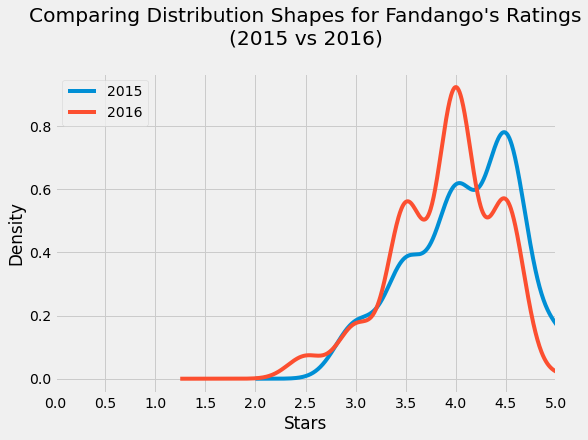

In [13]:
import matplotlib.pyplot as plt
from numpy import arange
%matplotlib inline
plt.style.use('fivethirtyeight')

fandango_2015['Fandango_Stars'].plot.kde(label = '2015', legend = True, figsize = (8,5.5))
fandango_2016['fandango'].plot.kde(label = '2016', legend = True)

plt.title("Comparing Distribution Shapes for Fandango's Ratings\n(2015 vs 2016)", y = 1.07)
plt.xlabel('Stars')
plt.xlim(0,5)
plt.xticks(arange(0,5.1,.5))
plt.show()

Now that we have the data plotted we can answer questions about the shape of the distribution, how their shapes compare, if there is any clear differentiation, and if we can see any evidence that would suggest if there is a change in ratings on Fandango's site in 2016 from 2015.

The first thing that is noticeable is how both distributions skew left. This suggests that movies on the site are generally given mostly high ratings. 

The other thing we see is that the 2015 distribution is slightly shifted to the right, suggesting that the ratings for these movies were likely enhanced a bit to show the popular movies as having rated higher to the customer. We could speculate that Fandango may have done this intentionally in order to encourage more people to buy tickets for these movies through their site. Because most of Fandango's revenue comes from selling movies tickets there could have been some interest in making the movies seem more appealing to the customer to encourage them to make a purchase.

## Comparing Relative Frequencies

Comparing these distributions with kernel density plots is a great start, but now we'll want to analyze some more granular information. We'll examine frequency tables for the two distributions, normalizing the tables by showing percentages.

In [14]:
print('2015' + '\n' + '-' * 16) # formatting the table
fandango_2015['Fandango_Stars'].value_counts(normalize = True).sort_index() * 100

2015
----------------


3.0     8.527132
3.5    17.829457
4.0    28.682171
4.5    37.984496
5.0     6.976744
Name: Fandango_Stars, dtype: float64

In [15]:
print('2016' + '\n' + '-' * 16)
fandango_2016['fandango'].value_counts(normalize = True).sort_index() * 100

2016
----------------


2.5     3.141361
3.0     7.329843
3.5    24.083770
4.0    40.314136
4.5    24.607330
5.0     0.523560
Name: fandango, dtype: float64

We can clearly see a difference here. The number of popular movies with 5 star ratings in 2016 was only 0.5% compared to 7% the year before. The most frequent rating in 2016 was 4 stars, but it 2015 it was 4.5 stars.

The lower ratings were also different. In 2015 there were no movies below 3 stars, but in 2016 3% are at 2.5 stars.


## Comparing Summary Statistics

next we'll look at the summary metrics to help us get a more precise view of the direction of the change.

In [16]:
mean_2015 = round(fandango_2015['Fandango_Stars'].mean(), 2)
mean_2016 = round(fandango_2016['fandango'].mean(), 2)

median_2015 = round(fandango_2015['Fandango_Stars'].median(), 2)
median_2016 = round(fandango_2016['fandango'].median(), 2)

mode_2015 = round(fandango_2015['Fandango_Stars'].mode()[0], 2)
mode_2016 = round(fandango_2016['fandango'].mode()[0], 2)

sum_stat = pd.DataFrame()
sum_stat['2015'] = [mean_2015, median_2015, mode_2015]
sum_stat['2016'] = [mean_2016, median_2016, mode_2016]
sum_stat.index = ['mean', 'median', 'mode']

sum_stat

,2015,2016
mean,4.09,3.89
median,4.00,4.00
mode,4.50,4.00


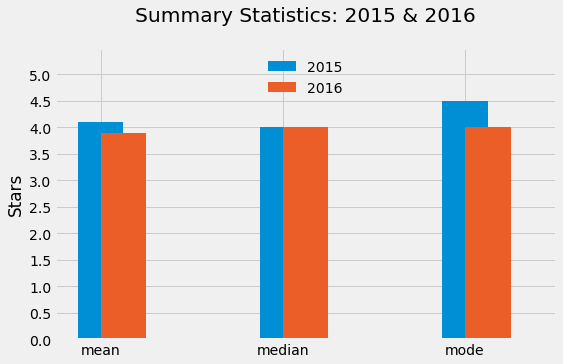

In [17]:
sum_stat['2015'].plot.bar(align = 'center', label = '2015', width = .25)
sum_stat['2016'].plot.bar(color = '#EB5E28', align = 'edge', label = '2016', width = .25, rot = 0, figsize = (8,5))

plt.title('Summary Statistics: 2015 & 2016', y = 1.07)
plt.ylim(0,5.5)
plt.yticks(arange(0,5.1,.5))
plt.ylabel('Stars')
plt.legend(framealpha = 0, loc = 'upper center')
plt.show()

The median is equal for both distributions, but the mode is lower in 2016 by a half star. That, coupled with the direction of change that we can see on the kernel density plot, confirms that on average, the popular movies released in 2016 are rated lower than the popular movies released in 2015.

## Conclusion & Next Steps

In this project we showed that there is a slight difference between Fandango's ratings for popular movies in 2015 vs 2016, and on average the movies released in 2016 were rated lower Fandango than those released in 2015. While we can't be sure why there was a change, we can assume that Fandango fixed their biased rating system after Hickey released his analysis.

If we want to continue this project, we should consider doing the following:

* Customize our graphs more to match something similar to FiveThirtyEight's style.
* Compare different movie rating sites in order to recommend the best website for checking movie ratings.
* Collect recent movie ratings data to see how the ratings compare year to year.

The idea for this project comes from the [DATAQUEST](https://app.dataquest.io/) **Statistics Fundamentals** course.